In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
import zipfile
import requests
from io import BytesIO

url = 'download_url'
response = requests.get(url, stream=True)

if response.status_code == 200:
    zip_file = zipfile.ZipFile(BytesIO(response.content))
    zip_file.extractall('/content/architect')
    print("Датасет завантажено.")
else:
    print("Не вдалось завантажити датасет.")


Files extracted successfully.
Extracted files:


['.config', 'drive', 'architect', 'sample_data']

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns
import shutil

from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.models import load_model

from pathlib import Path
import os.path

from sklearn.metrics import classification_report, confusion_matrix
sns.set_style('whitegrid')

In [ ]:
import zipfile
zip_file = zipfile.ZipFile('/content/drive/MyDrive/architecture-dataset-resized.zip')
zip_file.extractall('/content/architect')

In [ ]:

arch_zero_folder = 'Architecture ZERO'
arch_zero_validation_folder = 'Architecture Validation ZERO'

def gdrive_dataset_path(folder):
    return f'/content/drive/MyDrive/{folder}'

def local_dataset_path(folder):
    return f'/content/dataset/{folder}'

In [ ]:
for folder in [arch_zero_folder, arch_zero_validation_folder]:
    if not os.path.exists(local_dataset_path(folder)):
        shutil.copytree(gdrive_dataset_path(folder), local_dataset_path(folder))

In [ ]:
shutil.copytree(gdrive_dataset_path(arch_zero_validation_folder), local_dataset_path(arch_zero_validation_folder))

'/content/dataset/Architecture Validation ZERO'

In [ ]:
arch_train_dataset = '/content/architect/arch-dataset'
arch_val_dataset = '/content/architect/arch-dataset-val'
arch_test_dataset = '/content/architect/arch-dataset-test'

In [ ]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [ ]:
dataset = local_dataset_path(arch_zero_folder)
test_dataset = local_dataset_path(arch_zero_validation_folder)

In [ ]:
def get_image_df(path):
  images = Path(path)

  files = list(images.glob(r'**/*.JPG')) + list(images.glob(r'**/*.jpg')) + list(images.glob(r'**/*.png')) + list(images.glob(r'**/*.PNG'))
  labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], files))

  filesPD = pd.Series(files, name='Filepath').astype(str)
  labelsPD = pd.Series(labels, name='Label')

  image_df = pd.concat([filesPD, labelsPD], axis=1)
  return image_df

In [ ]:
train_image_df = get_image_df(arch_train_dataset)
val_image_df = get_image_df(arch_val_dataset)
test_image_df = get_image_df(arch_test_dataset)

In [ ]:
print(train_image_df)
print(val_image_df)
print(test_image_df)

                                               Filepath  \
0     /content/architect/arch-dataset/Novelty/1436_4...   
1     /content/architect/arch-dataset/Novelty/383_45...   
2     /content/architect/arch-dataset/Novelty/1443_M...   
3     /content/architect/arch-dataset/Novelty/1752_4...   
4     /content/architect/arch-dataset/Novelty/1417_4...   
...                                                 ...   
2741  /content/architect/arch-dataset/Reneissance an...   
2742  /content/architect/arch-dataset/Reneissance an...   
2743  /content/architect/arch-dataset/Reneissance an...   
2744  /content/architect/arch-dataset/Reneissance an...   
2745  /content/architect/arch-dataset/Reneissance an...   

                        Label  
0                     Novelty  
1                     Novelty  
2                     Novelty  
3                     Novelty  
4                     Novelty  
...                       ...  
2741  Reneissance and Baroque  
2742  Reneissance and Baroque  
274

In [ ]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(dataset).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

<ipython-input-17-1a772792dbbe>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='rocket')


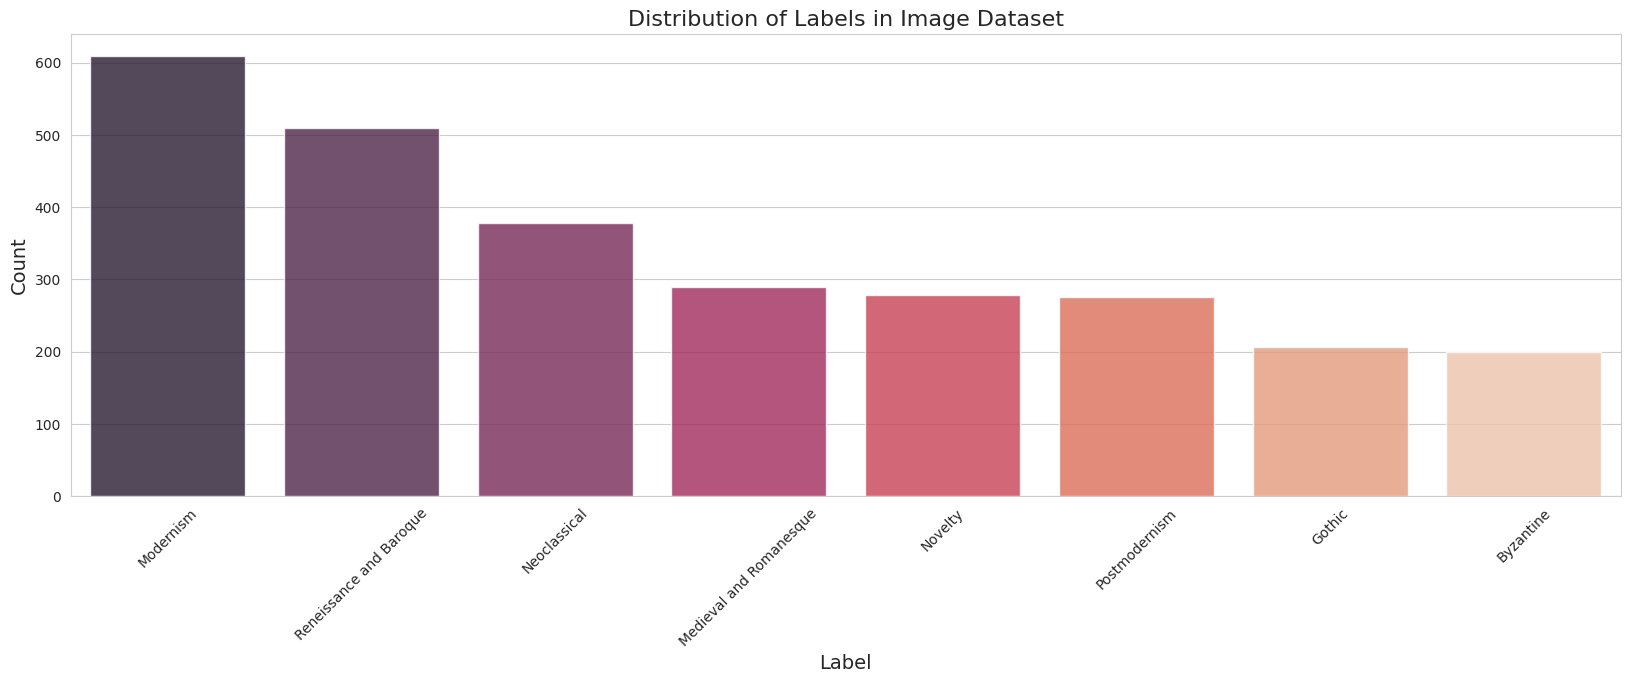

In [ ]:
label_counts = train_image_df['Label'].value_counts()

plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='rocket')
plt.title('Distribution of Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

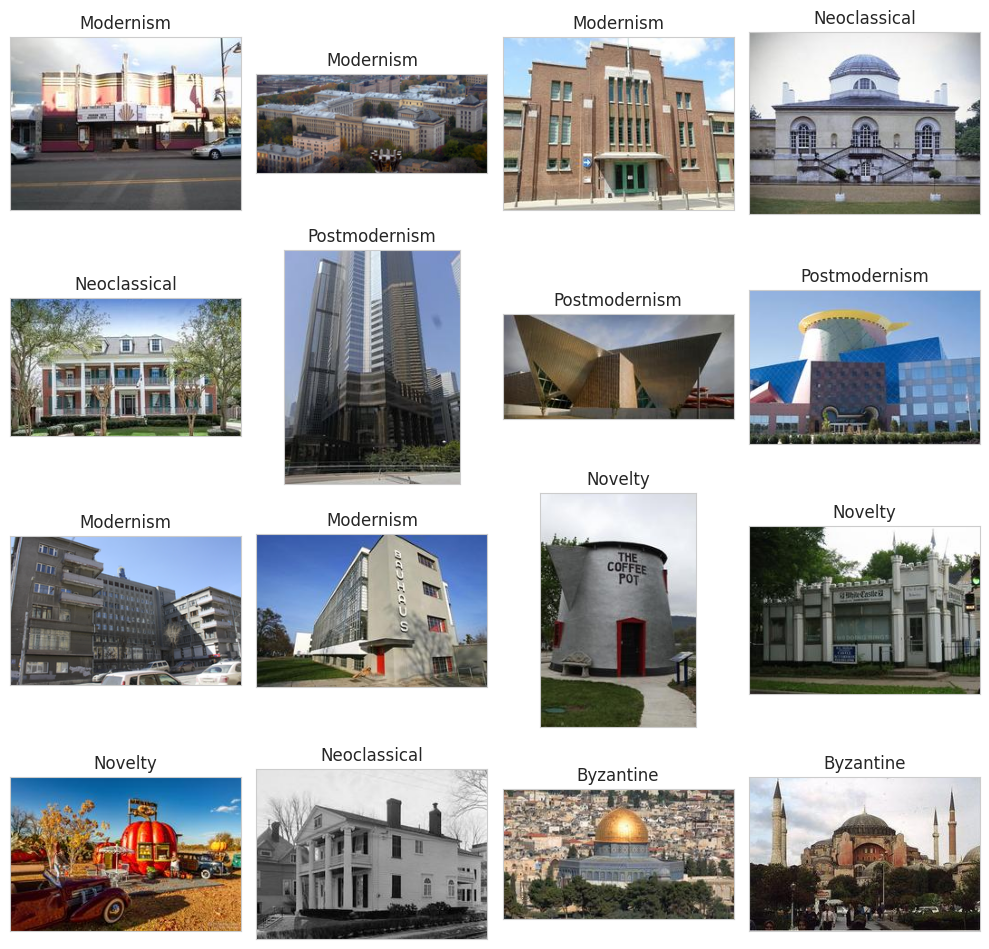

In [ ]:
random_index = np.random.randint(0, len(train_image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(train_image_df.Filepath[random_index[i]]))
    ax.set_title(train_image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [ ]:
train_df, val_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.4,
    zoom_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest'
)


val_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_image_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_image_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)


Found 2746 validated image filenames belonging to 8 classes.
Found 552 validated image filenames belonging to 8 classes.


In [ ]:

test_images = val_generator.flow_from_dataframe(
    dataframe=test_image_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 542 validated image filenames belonging to 8 classes.


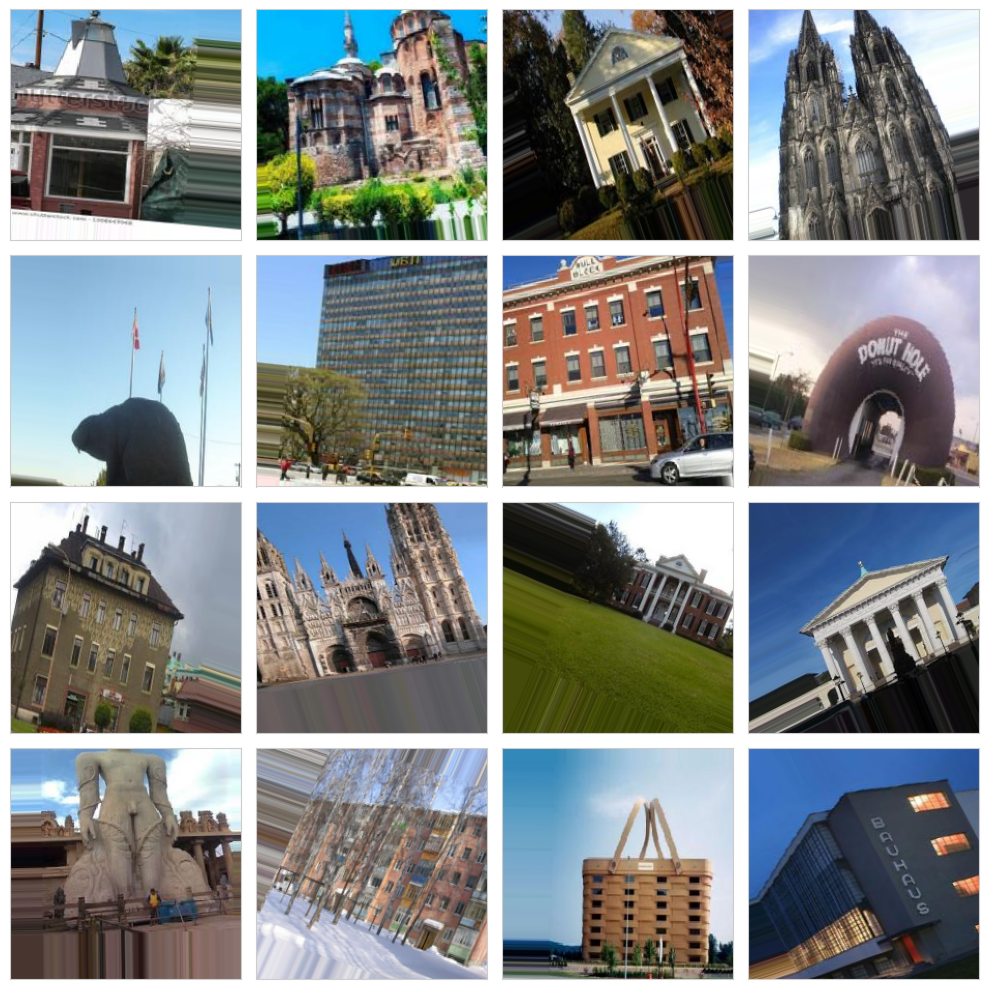

In [ ]:
batch_images, batch_labels = next(train_images)

num_samples = min(16, batch_images.shape[0])
random_indices = np.random.choice(batch_images.shape[0], num_samples, replace=False)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    if i < num_samples:
        ax.imshow(batch_images[random_indices[i]].astype(np.uint8))

plt.tight_layout()
plt.show()


In [ ]:
class_labels = list(test_images.class_indices.keys())
print(class_labels)

['Byzantine', 'Gothic and Gothic Revival', 'Medieval and Romanesque', 'Modernism', 'Neoclassical', 'Novelty', 'Postmodernism', 'Reneissance, Baroque and Baroque Revival']


In [ ]:
# augment = tf.keras.Sequential([
#   layers.Resizing(224,224),
#   layers.Rescaling(1./255),
#   layers.RandomFlip("horizontal"),
#   layers.RandomRotation(0.1),
#   layers.RandomZoom(0.1),
#   layers.RandomContrast(0.1),
# ])

In [ ]:
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB7(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)
# pretrained_model = tf.keras.applications.VGG16(
#     input_shape=(224, 224, 3),
#     include_top=False,
#     weights='imagenet',
#     pooling='max'
# )
# pretrained_model = tf.keras.applications.InceptionV3(
#     input_shape=(224, 224, 3),
#     include_top=False,
#     weights='imagenet',
#     pooling='max'
# )


pretrained_model.trainable = False

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:

checkpoint_path = "model-efficientnet.weights.h5"
# checkpoint_path = "model-vgg"

checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [ ]:
early_stopping = EarlyStopping(
    monitor = "val_loss",
    patience = 5,
    restore_best_weights = True
)

In [ ]:
inputs = pretrained_model.input

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)


outputs = Dense(len(class_labels), activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)


In [ ]:
model.summary()
len(model.layers)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 64)   │          1,728 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 64)   │            256 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 64)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 64)   │            576 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 64)   │            256 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 64)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 64)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 64)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 16)       │          1,040 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 64,460,575 (245.90 MB)

 Trainable params: 362,888 (1.38 MB)

 Non-trainable params: 64,097,687 (244.51 MB)

820

In [ ]:

model.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history_dict):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history_dict['loss'], label='Train Loss', marker='o')
    if 'val_loss' in history_dict:
        plt.plot(history_dict['val_loss'], label='Validation Loss', marker='o')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    if 'accuracy' in history_dict:
        plt.plot(history_dict['accuracy'], label='Train Accuracy', marker='o')
    if 'val_accuracy' in history_dict:
        plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
def draw_confusion_matrix(predictions):
  true_classes = test_images.classes
  class_labels = list(test_images.class_indices.keys())

  predicted_classes = np.argmax(predictions, axis=1)

  conf_matrix = confusion_matrix(true_classes, predicted_classes)

  plt.figure(figsize=(10, 8))
  sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

  plt.xlabel("Predicted Class")
  plt.ylabel("True Class")
  plt.title("Confusion Matrix")
  plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, classification_report
def print_report(predictions):
  predicted_classes = np.argmax(predictions, axis=1)

  true_classes = test_images.classes
  class_labels = list(test_images.class_indices.keys())

  accuracy = accuracy_score(true_classes, predicted_classes)
  print(f"Manual Test Accuracy: {accuracy:.4f}")
  print(classification_report(true_classes, predicted_classes, target_names=class_labels))

In [ ]:

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=50,
    callbacks=[
        early_stopping,
        checkpoint_callback,
    ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.1980 - loss: 2.5063 - val_accuracy: 0.3895 - val_loss: 1.6551
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 77s 560ms/step - accuracy: 0.3439 - loss: 1.7556 - val_accuracy: 0.4764 - val_loss: 1.4550
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 82s 563ms/step - accuracy: 0.3976 - loss: 1.6009 - val_accuracy: 0.5181 - val_loss: 1.2959
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 48s 561ms/step - accuracy: 0.4192 - loss: 1.5525 - val_accuracy: 0.5380 - val_loss: 1.2564
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 48s 553ms/step - accuracy: 0.4247 - loss: 1.5167 - val_accuracy: 0.5399 - val_loss: 1.2842
Epoch 6/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 84s 579ms/step - accuracy: 0.4621 - loss: 1.4647 - val_accuracy: 0.5978 - val_loss: 1.2353
Epoch 7/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 46s 535ms/step - accuracy: 0.4571 - loss: 1.4337 - val_accuracy: 0.5507 - val_loss: 1.2390
Epoch 8/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 82s 540ms/step - accuracy: 0.4923 - loss: 1.3612 - val_accura

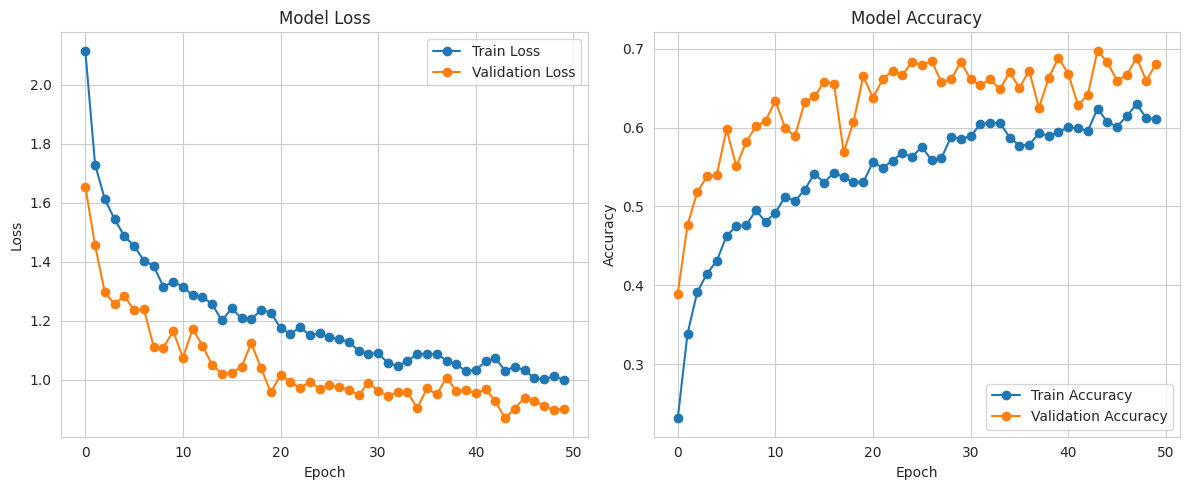

In [ ]:
plot_training_history(history.history)

In [ ]:
trainable_layers_num = len(pretrained_model.layers)

In [ ]:
unfreeze_num_layers = int(trainable_layers_num*0.1)
pretrained_model.trainable = True
for layer in pretrained_model.layers[:-unfreeze_num_layers]:
  layer.trainable = False
for layer in pretrained_model.layers[-unfreeze_num_layers:]:
  layer.trainable = True

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history1 = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=50,
    callbacks=[
        early_stopping,
        checkpoint_callback,
    ]
)

Epoch 1/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.4184 - loss: 2.0193 - val_accuracy: 0.6685 - val_loss: 0.9141
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 78s 732ms/step - accuracy: 0.5996 - loss: 1.0580 - val_accuracy: 0.6993 - val_loss: 0.8659
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 61s 711ms/step - accuracy: 0.6492 - loss: 0.9551 - val_accuracy: 0.7264 - val_loss: 0.7848
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 84s 738ms/step - accuracy: 0.6859 - loss: 0.8671 - val_accuracy: 0.7717 - val_loss: 0.7334
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 71s 610ms/step - accuracy: 0.7022 - loss: 0.8196 - val_accuracy: 0.7645 - val_loss: 0.7117
Epoch 6/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 97s 788ms/step - accuracy: 0.7211 - loss: 0.7265 - val_accuracy: 0.7790 - val_loss: 0.6834
Epoch 7/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 51s 586ms/step - accuracy: 0.7294 - loss: 0.6983 - val_accuracy: 0.7772 - val_loss: 0.6855
Epoch 8/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 91s 686ms/step - accuracy: 0.7412 - loss: 0.6562 - val_accura

In [ ]:
model_save_path = '/content/drive/MyDrive/models/efficientnet_finetuned_model_50_plus_50.keras'
model.save(model_save_path)

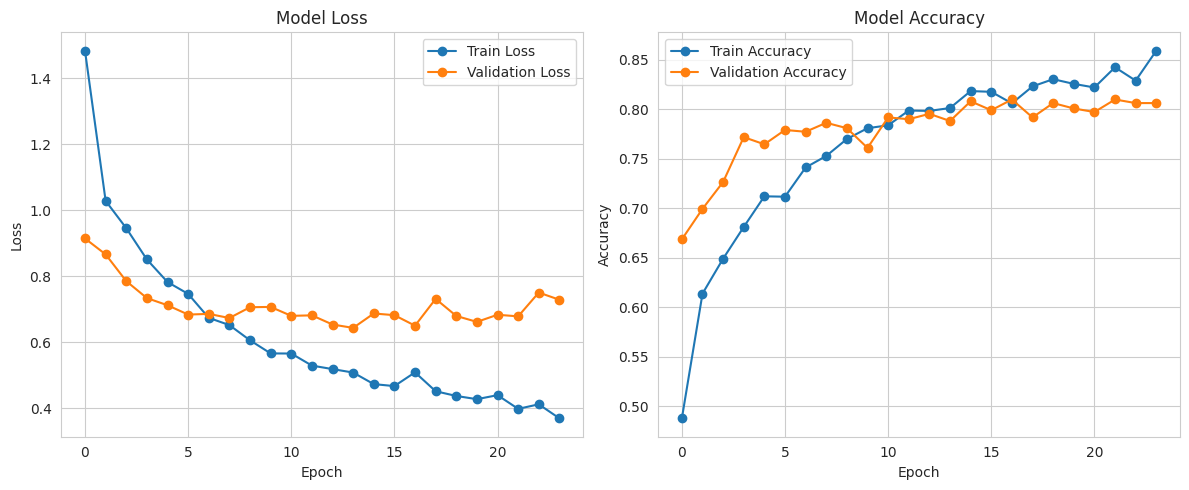

In [ ]:
plot_training_history(history1.history)

In [ ]:
val_loss, val_acc = model.evaluate(val_images, verbose=1)
print("Validation Loss: {:.4f}".format(val_loss))
print("Validation Accuracy: {:.4f}".format(val_acc))

test_loss, test_acc = model.evaluate(test_images, verbose=1)
print("Test Loss: {:.4f}".format(test_loss))
print("Test Accuracy: {:.4f}".format(test_acc))


18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 450ms/step - accuracy: 0.8233 - loss: 0.6291
Validation Loss: 0.6669
Validation Accuracy: 0.7935


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8072 - loss: 0.5354
Test Loss: 0.6138
Test Accuracy: 0.7860


In [ ]:
unfreeze_num_layers = int(trainable_layers_num*0.33)
pretrained_model.trainable = True
for layer in pretrained_model.layers[:-unfreeze_num_layers]:
  layer.trainable = False
for layer in pretrained_model.layers[-unfreeze_num_layers:]:
  layer.trainable = True

In [ ]:

model.compile(
    optimizer=Adam(learning_rate=0.00003),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history2 = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=50,
    callbacks=[
        early_stopping,
        checkpoint_callback,
    ]
)

Epoch 1/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.7471 - loss: 0.7002 - val_accuracy: 0.8152 - val_loss: 0.5959
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 74s 616ms/step - accuracy: 0.7792 - loss: 0.6007 - val_accuracy: 0.7844 - val_loss: 0.6951
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 84s 643ms/step - accuracy: 0.7784 - loss: 0.5909 - val_accuracy: 0.8025 - val_loss: 0.6540
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 53s 610ms/step - accuracy: 0.8008 - loss: 0.5329 - val_accuracy: 0.7899 - val_loss: 0.6678
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 55s 636ms/step - accuracy: 0.8156 - loss: 0.5076 - val_accuracy: 0.7989 - val_loss: 0.6406
Epoch 6/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 80s 612ms/step - accuracy: 0.8188 - loss: 0.4604 - val_accuracy: 0.8025 - val_loss: 0.6791
Epoch 7/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 53s 613ms/step - accuracy: 0.8060 - loss: 0.4787 - val_accuracy: 0.7844 - val_loss: 0.6639
Epoch 8/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 53s 612ms/step - accuracy: 0.8110 - loss: 0.4493 - val_accura

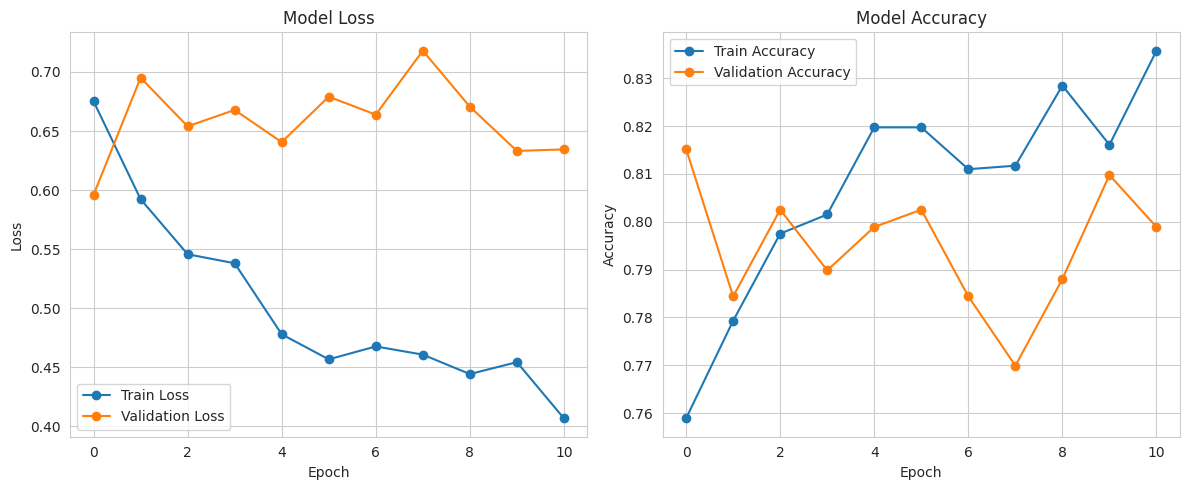

In [ ]:
plot_training_history(history2.history)

In [ ]:
model_save_path = '/content/drive/MyDrive/models/efficientnet_finetuned_model_50_plus_50_try2.keras'
model.save(model_save_path)

In [ ]:
val_loss, val_acc = model.evaluate(val_images, verbose=1)
print("Validation Loss: {:.4f}".format(val_loss))
print("Validation Accuracy: {:.4f}".format(val_acc))

test_loss, test_acc = model.evaluate(test_images, verbose=1)
print("Test Loss: {:.4f}".format(test_loss))
print("Test Accuracy: {:.4f}".format(test_acc))

18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 447ms/step - accuracy: 0.8017 - loss: 0.6274
Validation Loss: 0.5817
Validation Accuracy: 0.8098
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 768ms/step - accuracy: 0.8197 - loss: 0.4928
Test Loss: 0.5795
Test Accuracy: 0.8063


In [ ]:
predictions = model.predict(test_images)

17/17 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step


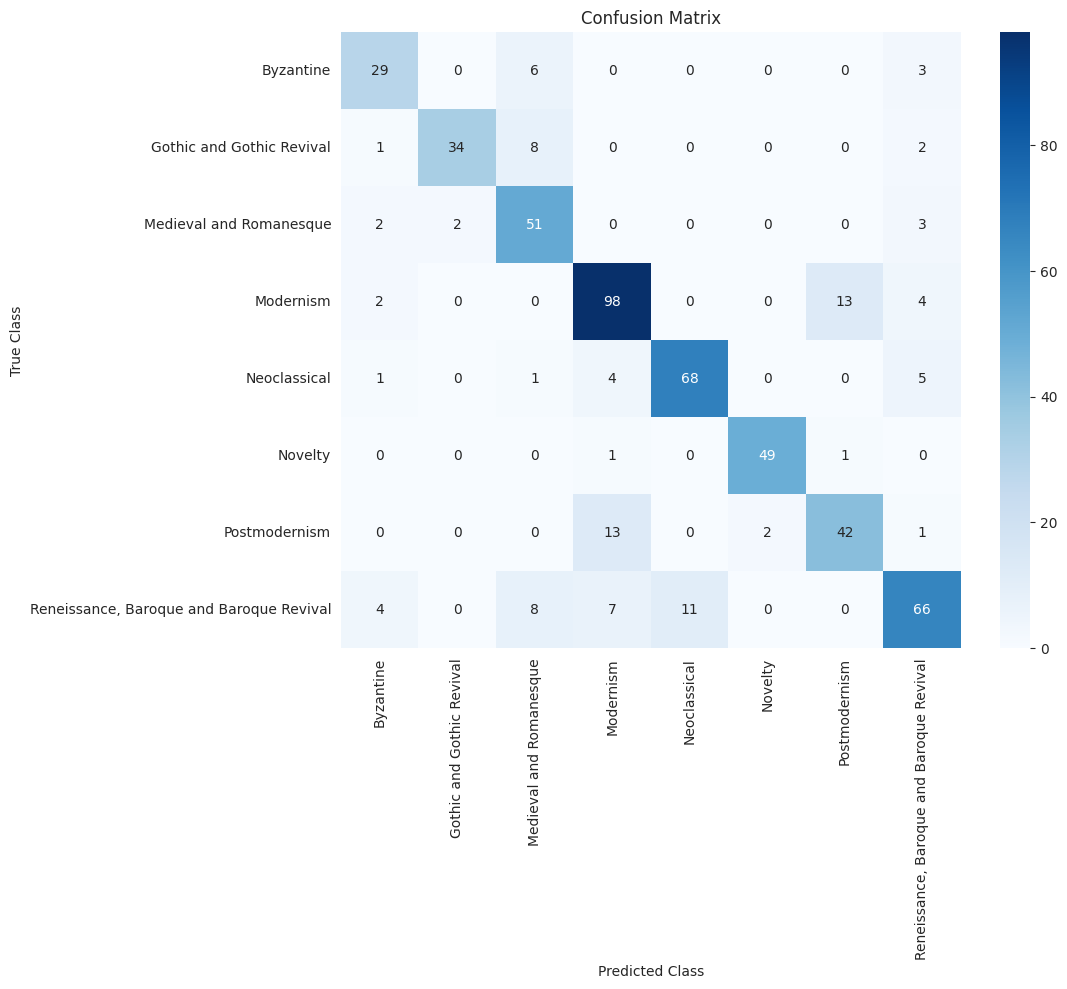

In [ ]:
draw_confusion_matrix(predictions)

In [ ]:
trainable_layers_num = len(pretrained_model.layers)
print(trainable_layers_num)

815


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.000005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
unfreeze_num_layers = int(trainable_layers_num*0.4)

In [ ]:
pretrained_model.trainable = True
for layer in pretrained_model.layers[:-unfreeze_num_layers]:
  layer.trainable = False
for layer in pretrained_model.layers[-unfreeze_num_layers:]:
  layer.trainable = True

In [ ]:
history3 = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=50,
    callbacks=[
        early_stopping,
        checkpoint_callback,
    ]
)

Epoch 1/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.7926 - loss: 0.5714 - val_accuracy: 0.7899 - val_loss: 0.6399
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 57s 664ms/step - accuracy: 0.7939 - loss: 0.5265 - val_accuracy: 0.7862 - val_loss: 0.6947
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 55s 639ms/step - accuracy: 0.7773 - loss: 0.5551 - val_accuracy: 0.7717 - val_loss: 0.6642
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 53s 619ms/step - accuracy: 0.8017 - loss: 0.5385 - val_accuracy: 0.7736 - val_loss: 0.6576
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 53s 614ms/step - accuracy: 0.7965 - loss: 0.5211 - val_accuracy: 0.7953 - val_loss: 0.6451
Epoch 6/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 55s 636ms/step - accuracy: 0.7964 - loss: 0.5282 - val_accuracy: 0.7627 - val_loss: 0.7092
Epoch 7/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 80s 618ms/step - accuracy: 0.7838 - loss: 0.5192 - val_accuracy: 0.7645 - val_loss: 0.7074
Epoch 8/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 54s 624ms/step - accuracy: 0.8111 - loss: 0.5099 - val_accura

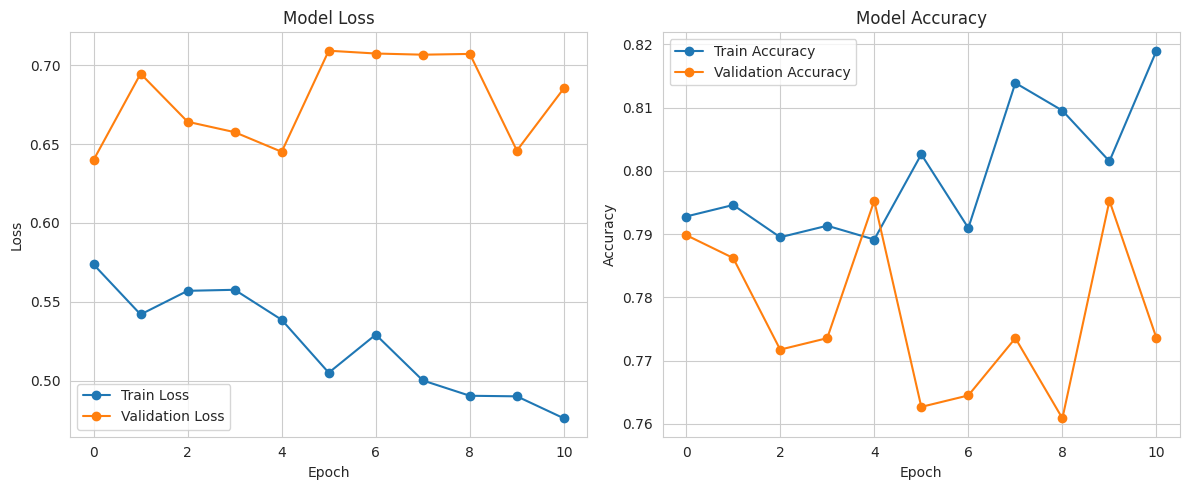

In [ ]:
plot_training_history(history3.history)

In [ ]:
model_save_path = '/content/drive/MyDrive/models/efficientnet_finetuned_model_try3.keras'
model.save(model_save_path)

In [ ]:
val_loss, val_acc = model.evaluate(val_images, verbose=1)
print("Validation Loss: {:.4f}".format(val_loss))
print("Validation Accuracy: {:.4f}".format(val_acc))

test_loss, test_acc = model.evaluate(test_images, verbose=1)
print("Test Loss: {:.4f}".format(test_loss))
print("Test Accuracy: {:.4f}".format(test_acc))

18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 461ms/step - accuracy: 0.7754 - loss: 0.6966
Validation Loss: 0.6783
Validation Accuracy: 0.7790
17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8086 - loss: 0.5042
Test Loss: 0.5866
Test Accuracy: 0.7915


In [ ]:
predictions = model.predict(test_images)
print_report(predictions)

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 227ms/step
Manual Test Accuracy: 0.7915
                                          precision    recall  f1-score   support

                               Byzantine       0.74      0.68      0.71        38
               Gothic and Gothic Revival       0.94      0.76      0.84        45
                 Medieval and Romanesque       0.65      0.86      0.74        58
                               Modernism       0.78      0.85      0.81       117
                            Neoclassical       0.86      0.87      0.87        79
                                 Novelty       0.94      0.96      0.95        51
                           Postmodernism       0.76      0.66      0.70        58
Reneissance, Baroque and Baroque Revival       0.76      0.66      0.70        96

                                accuracy                           0.79       542
                               macro avg       0.80      0.79      0.79       542
                          

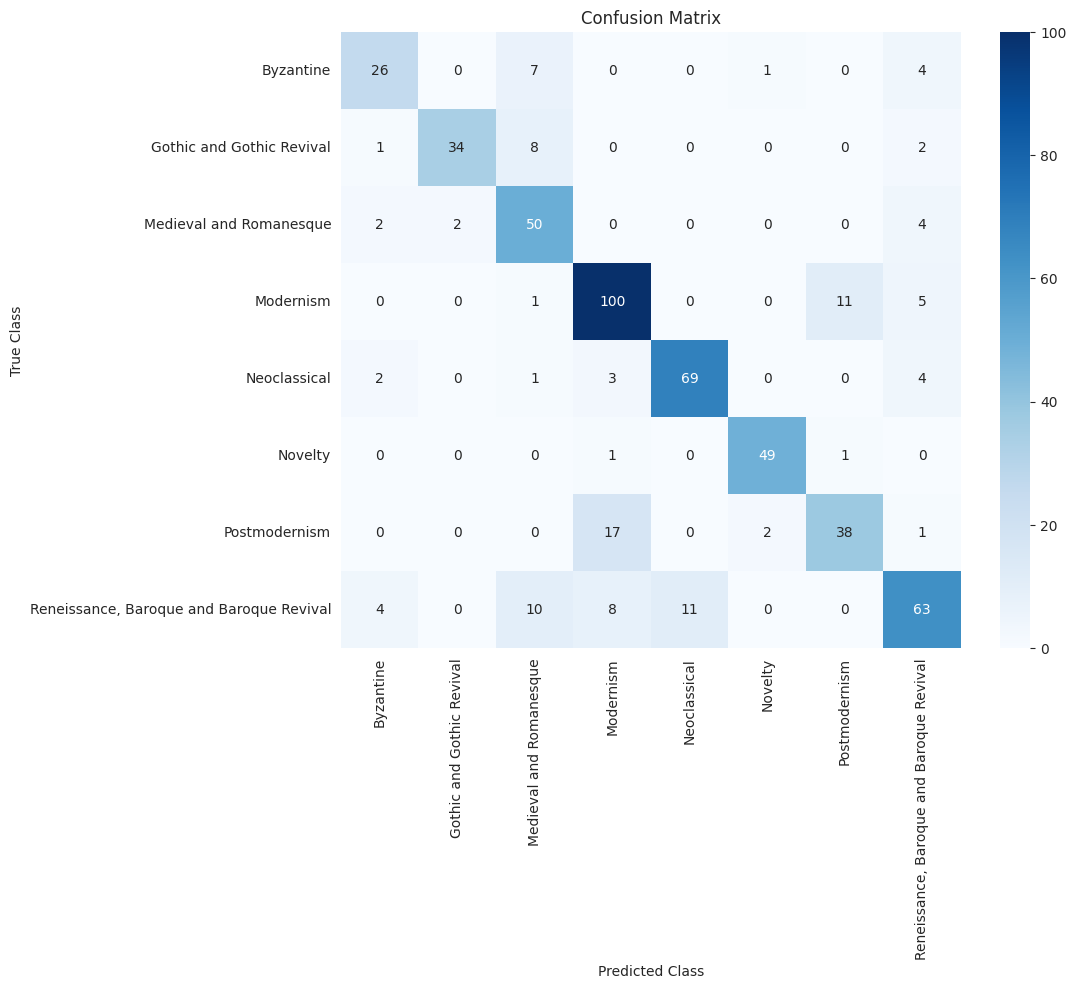

In [ ]:
draw_confusion_matrix(predictions)

In [ ]:
model = load_model('/content/drive/MyDrive/models/[new]efficient_net_epochs_100(maybe_less).h5')

In [ ]:
for i in range(80):
  model.layers[len(model.layers)-1-i].trainable = True

In [ ]:
print(len(model.layers))

25


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
test_loss, test_accuracy = model.evaluate(test_images)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 54s 995ms/step - accuracy: 0.5689 - loss: 1.3581
Test Accuracy: 0.6288, Test Loss: 1.1667


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
def draw_confusion_matrix(predictions):
  true_classes = test_images.classes
  class_labels = list(test_images.class_indices.keys())

  predicted_classes = np.argmax(predictions, axis=1)

  conf_matrix = confusion_matrix(true_classes, predicted_classes)

  plt.figure(figsize=(10, 8))
  sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

  plt.xlabel("Predicted Class")
  plt.ylabel("True Class")
  plt.title("Confusion Matrix")
  plt.show()


In [ ]:
draw_confusion_matrix(predictions)

In [ ]:
import pickle

with open('/content/drive/MyDrive/models/vgg_finetune2.4_10stop_1e-5_history.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
import pickle

with open('/content/drive/MyDrive/models/model01_history.pkl', 'rb') as file_pi:
    history1 = pickle.load(file_pi)

with open('/content/drive/MyDrive/models/model_150_history.pkl', 'rb') as file_pi:
    history2 = pickle.load(file_pi)

with open('/content/drive/MyDrive/models/model_150_plus_finetune_history.pkl', 'rb') as file_pi:
    history3 = pickle.load(file_pi)

In [ ]:
print(history1)

{'loss': [4.076266765594482, 3.254427433013916, 3.18422794342041, 3.1406683921813965, 3.1063947677612305, 3.075914144515991, 3.013213872909546, 2.9720258712768555, 2.917956590652466, 2.8698623180389404, 2.8348581790924072, 2.7842681407928467, 2.7613656520843506, 2.705493927001953, 2.675945281982422, 2.642721176147461, 2.616537094116211, 2.5979177951812744, 2.5552239418029785, 2.52898907661438, 2.50856351852417, 2.4753828048706055, 2.4675514698028564, 2.454680919647217, 2.4292654991149902, 2.3923890590667725, 2.3866164684295654, 2.3757967948913574, 2.3350484371185303, 2.3366124629974365, 2.313325881958008, 2.2942357063293457, 2.2758617401123047, 2.254260301589966, 2.2605388164520264, 2.2299532890319824, 2.2298262119293213, 2.2031121253967285, 2.201134204864502, 2.194559097290039, 2.1924068927764893, 2.1567797660827637, 2.157428503036499, 2.1408743858337402, 2.120814323425293, 2.120326519012451, 2.1158056259155273, 2.0761587619781494, 2.0888171195983887, 2.0883126258850098, 2.06546211242

In [ ]:
print(history2)

{'loss': [1.7019729614257812, 1.7098510265350342, 1.6908133029937744, 1.6959445476531982, 1.6807055473327637, 1.6818209886550903, 1.6804332733154297, 1.6760672330856323, 1.6620814800262451, 1.6504836082458496, 1.6513561010360718, 1.658758521080017, 1.6469686031341553, 1.6474418640136719, 1.633753776550293, 1.6350462436676025, 1.6263219118118286, 1.6300654411315918, 1.6212502717971802, 1.6042407751083374, 1.608892798423767, 1.6020184755325317, 1.6041134595870972, 1.6030868291854858, 1.604129433631897, 1.6065621376037598, 1.5706297159194946, 1.5773637294769287, 1.5811128616333008, 1.5716670751571655, 1.5763466358184814, 1.5667095184326172, 1.5688997507095337, 1.5647674798965454, 1.5433220863342285, 1.5337761640548706, 1.5487000942230225, 1.5524909496307373, 1.5324313640594482, 1.5388803482055664, 1.5395455360412598, 1.5341659784317017, 1.5137648582458496, 1.522676944732666, 1.5274646282196045, 1.5198928117752075, 1.5062302350997925, 1.5085760354995728, 1.5004945993423462, 1.4924144744873

In [ ]:
print(history3)

{'loss': [2.4194464683532715, 2.0027456283569336, 1.764999270439148, 1.602752923965454, 1.4605562686920166, 1.3411898612976074, 1.2357672452926636, 1.1520084142684937, 1.0642846822738647, 0.9847112894058228, 0.9269518256187439, 0.8576194643974304, 0.779322624206543, 0.7176640033721924, 0.6806983947753906, 0.6316145658493042, 0.5984788537025452, 0.5524007678031921, 0.5069357752799988, 0.4624394178390503, 0.4299580454826355, 0.4417218863964081, 0.3728635311126709, 0.36706942319869995, 0.34452953934669495, 0.3569091260433197, 0.32918781042099], 'accuracy': [0.2817942500114441, 0.36452004313468933, 0.4288173317909241, 0.4765087068080902, 0.523896336555481, 0.5562980771064758, 0.5930538773536682, 0.6220129728317261, 0.6473268270492554, 0.6750708818435669, 0.6962332725524902, 0.720332145690918, 0.7465572953224182, 0.7656946182250977, 0.780376672744751, 0.7981976270675659, 0.8109558820724487, 0.8261441588401794, 0.8412312865257263, 0.8542932271957397, 0.8631024956703186, 0.8644188046455383, 0

In [ ]:
import csv
file_name = "data.csv"

with open(file_name, mode='w', newline='') as file:
    writer = csv.writer(file)

    writer.writerow(['epoch','loss', 'accuracy', 'val_loss', 'val_accuracy'])

    for d in [history.history]:
      for i in range(len(d['loss'])):
        writer.writerow([i, *[d[key][i] for key in d.keys()]])

print("Дані були успішно записані у файл:", file_name)

Дані були успішно записані у файл: data.csv
